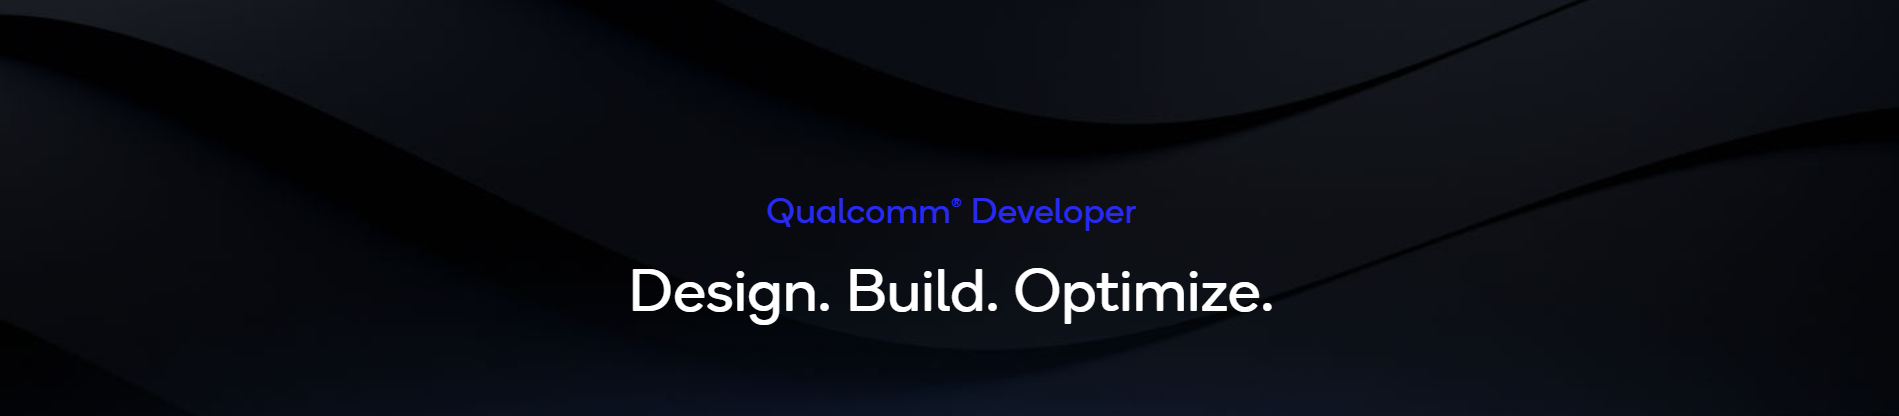

## Python Windows 64bit (x86_64)

In [45]:
# !powershell pip list

In [46]:
import platform
arch = platform.machine()
arch

'AMD64'

In [34]:
arch = platform.machine()
sys = platform.system()
processor = platform.processor()
print(f"{arch}\n{sys}\n{processor}")

AMD64
Windows
ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc


In [35]:
import onnxruntime as ort
import os
import torch

import cv2 as cv
import numpy as np

from torchvision.transforms import v2
from torchvision.transforms.functional import InterpolationMode
from PIL import Image
from pathlib import Path

In [36]:
root_dir = Path.cwd().parent
root_dir

WindowsPath('C:/Users/DFS/Desktop/gitrepo/qnn_sample_apps')

In [37]:
# ONNX Session Setup
model_subdirectory = "hrnet_pose"
model_name = "hrnet_pose.onnx" #hrnet_quantized.onnx|hrnet_pose.onnx
system = "aarch64-windows-msvc"
model_path = os.path.join(root_dir,"models",model_name)

backend_path_nuget = "C:/Users/DFS/Desktop/gitrepo/nuget_packages/Microsoft.ML.OnnxRuntime.QNN.1.20.1/runtimes/win-x64/native/QnnHtp.dll"
backend_path_qnn_sdk = "C:/Users/DFS/Desktop/qnn_sdk/qairt/2.26.0.240828/lib/aarch64-windows-msvc/QnnHtp.dll"

# sess_options = ort.SessionOptions()
# sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

qnn_provider_options = {
    "backend_path": backend_path_nuget
}

session = ort.InferenceSession(model_path,
                               # sess_options,
                                providers= [("QNNExecutionProvider",qnn_provider_options),"CPUExecutionProvider"],
                              )

inputs = session.get_inputs()
outputs = session.get_outputs()
input_0 = inputs[0] 
output_0 = outputs[0]
session.get_providers()

['CPUExecutionProvider']

In [38]:
print(f"Expected Input Shape: {input_0.shape}")
print(f"Expected Input Type: {input_0.type}")
print(f"Expected Input Name: {input_0.name}")

Expected Input Shape: [1, 3, 256, 192]
Expected Input Type: tensor(float)
Expected Input Name: image


In [39]:
print(f"Expected Output Shape: {output_0.shape}")
print(f"Expected Output Type: {output_0.type}")
print(f"Expected Output Name: {output_0.name}")

Expected Output Shape: [1, 17, 64, 48]
Expected Output Type: tensor(float)
Expected Output Name: heatmaps


In [40]:
session.get_session_options()

In [41]:
session.get_modelmeta()

### Input Frame needs to be transformed to the below parameters based on get_inputs()
1. Shape: (1,3,256,192) => (B,C,H,W)
2. Datatype: Float 32
3. Name: Image

In [42]:
# PyTorch Frame Transform Setup
expected_shape = input_0.shape

transformer = v2.Compose([
    v2.Resize(size=(expected_shape[2],expected_shape[3]),interpolation=InterpolationMode.BICUBIC),
    # This automatically scales the image as well
    v2.ToDtype(torch.float32),  
    v2.ToTensor()
])


In [43]:
def keypoint_processor(post_inference_array: np.ndarray, scaler_height: int, scaler_width: int) -> list:
    keypoint_coordinates = []

    for keypoint in range(post_inference_array.shape[0]):
        heatmap = post_inference_array[keypoint]
       
        # Find the index of the maximum value in the heatmap
        max_val_index = torch.argmax(heatmap)
        
        # Convert the flat index to a 2D coordinates (row, column)
        img_height, img_width = torch.unravel_index(max_val_index, heatmap.shape)

        # Scale the coordinates
        coords = (int(img_height*scaler_height), int(img_width*scaler_width))
        keypoint_coordinates.append(coords)

    return keypoint_coordinates

In [44]:
cap = cv.VideoCapture(0)

if not cap.isOpened():
    print("Oh lordT")
    exit()

###########################################################################
## All of this is for scaling purposes ####################################
input_image_height, input_image_width = expected_shape[2], expected_shape[3]

# This is the heatmap shape after inference is performed => scaler is 4, that's the secret
heatmap_height, heatmap_width = 64, 48
scaler_height = input_image_height/heatmap_height
scaler_width = input_image_width/heatmap_width
###########################################################################

while True:
    # time.sleep(1)
    ret, hwc_frame = cap.read()

    if not ret:
        print("Can't receive frame (stream end?). Exiting...")
        break

    # 1.
    hwc_frame_pil = Image.fromarray(hwc_frame) 
    
    ###################################################
    #print(hwc_frame.size, hwc_frame.mode) #type PIL size only gives spatial, mode 
    ####################################################

    # 2.
    transform_frame = transformer(hwc_frame_pil) #(c,h,w)

    ####################################################
    #Scaling is being done somewhere within this transformer function
    # print(f"{np.array(frame).min()},{np.array(frame).max()}")

    #We need to reshape on transformed fram because transformation changes
    #pixel ranges from [0,255] -> [0,1]
    # [0,1] is an HRNet expectation as well
    ####################################################

    # 3.
    hwc_frame_np = transform_frame.permute(1,2,0).numpy() #(h,w,c)

    ########################################################################
    ## INFERENCE
    ########################################################################
    inference_frame = np.expand_dims(transform_frame, axis=0) #(1,c,h,w)
    outputs = session.run(None, {input_0.name:inference_frame})

    # 4.
    output_tensor = torch.tensor(outputs).squeeze(0).squeeze(0)

    keypoint_coordinate_list = keypoint_processor(output_tensor, scaler_height, scaler_width)
    ########################################################################
    ########################################################################
    ########################################################################
    
    # MAP KEYPOINTS BACK TO ORIGINAL FRAME THEN DISPLAY THAT FRAME
    # descale image
    # 5.
    frame = (hwc_frame_np*255).astype(np.uint8)
    frame = frame.copy()
    for (y,x) in keypoint_coordinate_list:
        cv.circle(frame, (x,y), radius=3, color=(0,0,255), thickness=-1)
        
    frame = cv.resize(frame, (640,480), interpolation=cv.INTER_CUBIC)    
    cv.imshow('frame',frame)
    if cv.waitKey(1) == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

In [146]:
cap.release()
cv.destroyAllWindows()

In [103]:
np.array(outputs).shape

(1, 1, 17, 64, 48)

In [24]:
keypoints_coordinates

[(48, 4),
 (112, 96),
 (120, 80),
 (32, 8),
 (32, 4),
 (16, 44),
 (48, 148),
 (164, 4),
 (168, 4),
 (192, 48),
 (244, 148),
 (8, 24),
 (0, 40),
 (236, 164),
 (220, 56),
 (244, 172),
 (248, 152)]

In [35]:
inference_frame.min()

0.007843138

In [36]:
inference_frame.max()

0.47843137

In [26]:
scaler_width

4.0

In [27]:
heatmap

tensor([[0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        ...,
        [0.0102, 0.0142, 0.0169,  ..., 0.0350, 0.0299, 0.0258],
        [0.0099, 0.0122, 0.0122,  ..., 0.0304, 0.0268, 0.0234],
        [0.0113, 0.0091, 0.0089,  ..., 0.0282, 0.0244, 0.0232]])

In [28]:
heatmap.shape

torch.Size([64, 48])

In [29]:
torch.argmax(heatmap)

tensor(3014)

In [30]:
np.unravel_index(np.argmax(heatmap), heatmap.shape)

(62, 38)

In [37]:
frame.min()

0

In [38]:
frame.max()

255

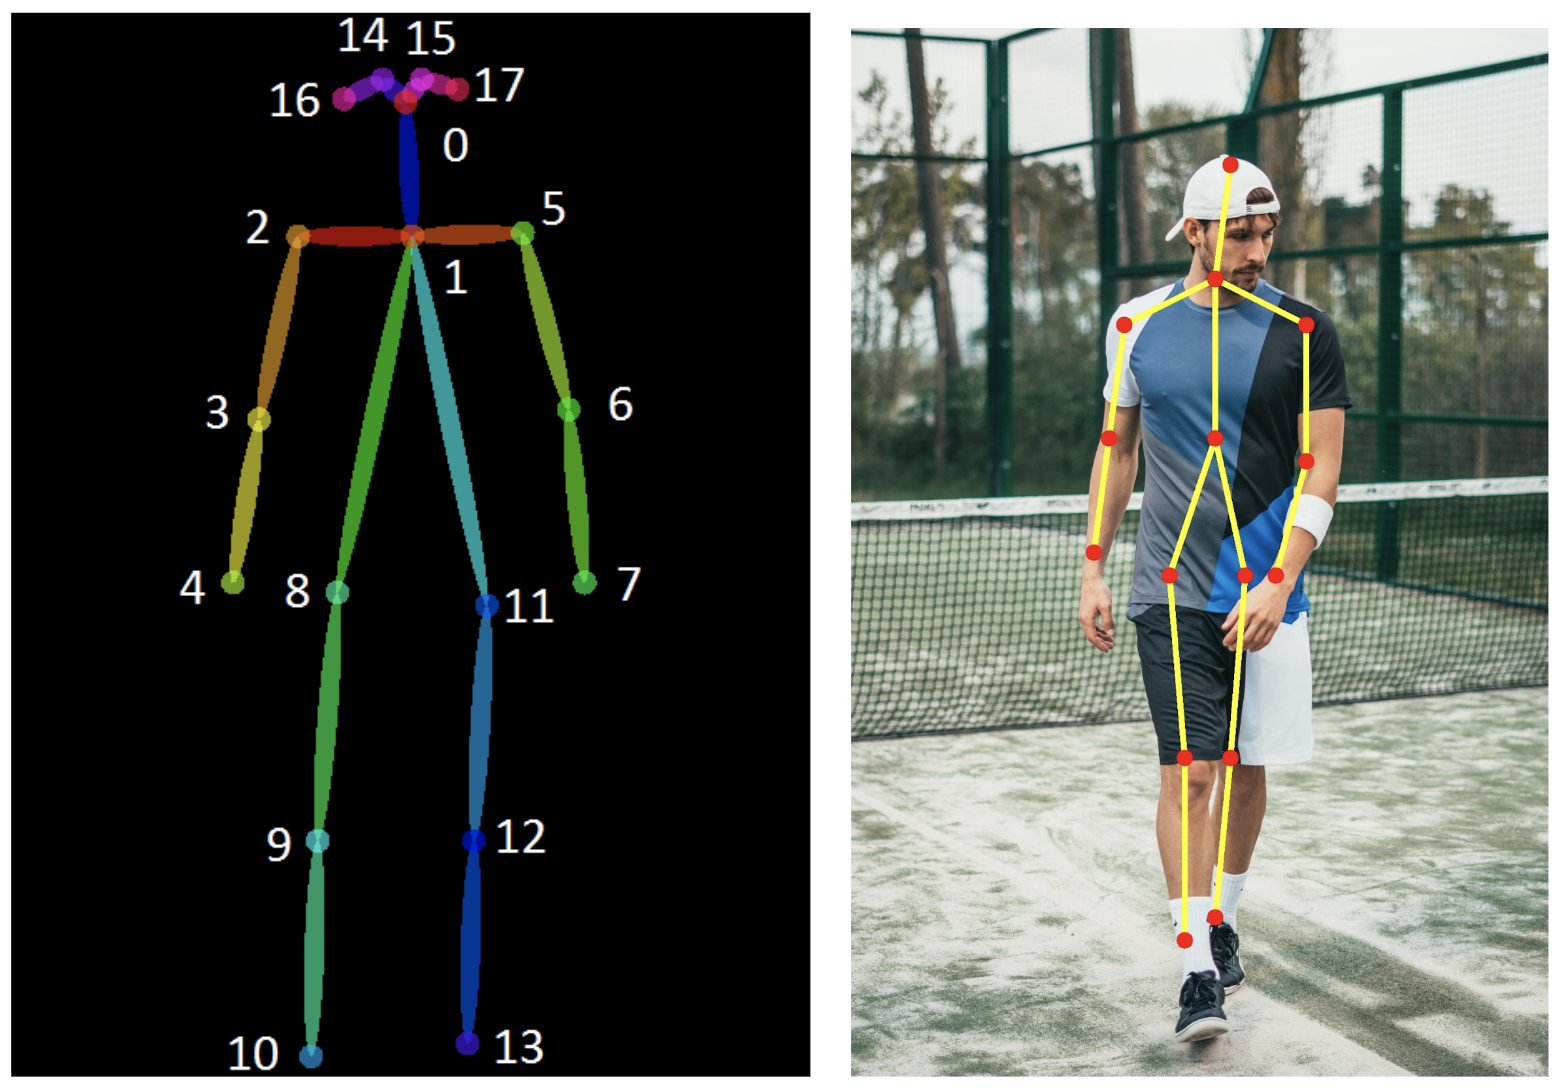